In [1]:
#  limitations under the License.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn import datasets, cross_validation, metrics
import tensorflow as tf

from tensorflow.contrib import learn
from tensorflow.contrib.learn import monitors


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [3]:
num_steps = 10

In [4]:
import pickle

In [5]:
import tensorflow as tf
tf.__version__

'0.9.0'

## Two Images Dataset

In [6]:
#benign_file = '/Users/chitrangtalaviya/Documents/Tensorflow/all-images/200X/benign_p/BENIGN0.p'
#malignant_file = '/Users/chitrangtalaviya/Documents/Tensorflow/all-images/200X/malignant_p/MALIGNANT0.p'
benign_file = 'small-data/BENIGN.pkl'
malignant_file = 'small-data/MALIGNANT.pkl'

benign_arr = pickle.load(open(benign_file, 'rb'))
malignant_arr = pickle.load(open(malignant_file, 'rb'))

(1009, 32, 32, 3)
(1009, 32, 32, 3)


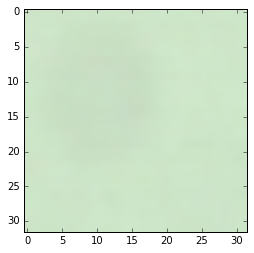

In [7]:
print(benign_arr.shape)
plt.imshow(benign_arr[0])
print(malignant_arr.shape)
plt.imshow(malignant_arr[0])

In [8]:
X = np.concatenate((benign_arr, malignant_arr), axis=0)
X.shape

(2018, 32, 32, 3)

In [9]:
y = np.concatenate((np.zeros(1009), np.ones(1009)))
y.shape

(2018,)

## Large Dataset

In [ ]:
# 623 benign
for i in range(0, 90):
    benign_file = '/home/ubuntu/BENIGN/BENIGN%s.p' % (i)
    benign_arr = pickle.load(open(benign_file))
    if X == None: X = benign_arr
    else:
        X = np.concatenate((X, benign_arr), axis = 0)

    # append benign targets
    if y == None: y = np.zeros(1009)
    else: y = np.concatenate((y, np.zeros(1009)), axis = 0)

# 1390 malignant
for i in range(0, 210):
    try:
        malignant_file = '/home/ubuntu/malignant_p/MALIGNANT%s.p' % (i)
        malignant_arr = pickle.load(open(malignant_file))
        if X == None: X = malignant_arr
        else:
            X = np.concatenate((X, malignant_arr), axis = 0)

        # append malignant targets
        if y == None: y = np.zeros(1009)
        else: y = np.concatenate((y, np.ones(1009)), axis = 0)
    except Exception, e:
        print(e)


## Run

In [10]:
fraction_test = 0.35
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                                                                     test_size=fraction_test,
                                                                     random_state=42)

In [ ]:
# Split X_train again to create validation data

#X_train, X_val, y_train, y_val = cross_validation.train_test_split(X_train,
#                                                                   y_train,
#                                                                   test_size=fraction_test,
#                                                                   random_state=42)

## Model Definition (for Train and Predict)

In [11]:
batch_size = X.shape[0]
test_size = X_test.shape[0]

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx

trX, trY, teX, teY = X_train, y_train, X_test, y_test

print (teY.shape)
print (teX.shape)
print (len(teX))


X = tf.placeholder("float", [None, 32, 32, 3])
Y = tf.placeholder("float", [None, 2])
Y1 = tf.placeholder("float", [test_size,])
w = init_weights([3, 3, 3, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 2])         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

# saver object
saver = tf.train.Saver()


(707,)
(707, 32, 32, 3)
707


## Train

In [12]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()
    
    for i in range(100):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX), batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],p_keep_conv: 0.8, p_keep_hidden: 0.5})

        test_indices = np.arange(len(teX)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]
        test_indices_yy = np.zeros(shape = (test_size, 2))
        #print (teX.shape)
        #print (test_indices.shape)
        test_indices_y = np.reshape(test_indices_yy , (2 , test_size))
    
        print(i, np.mean(np.argmax(teY[test_indices]) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         Y1: teY[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden: 1.0})))
        
        save_path = saver.save(sess, "/tmp/model.ckpt")
        print("Model saved in file: %s" % save_path)

0 0.0
Model saved in file: /tmp/model.ckpt
1 0.0
Model saved in file: /tmp/model.ckpt
2 0.983026874116
Model saved in file: /tmp/model.ckpt
3 0.983026874116
Model saved in file: /tmp/model.ckpt
4 0.983026874116
Model saved in file: /tmp/model.ckpt
5 0.016973125884
Model saved in file: /tmp/model.ckpt
6 0.0
Model saved in file: /tmp/model.ckpt
7 0.016973125884
Model saved in file: /tmp/model.ckpt
8 0.983026874116
Model saved in file: /tmp/model.ckpt
9 0.983026874116
Model saved in file: /tmp/model.ckpt
10 0.983026874116
Model saved in file: /tmp/model.ckpt
11 0.983026874116
Model saved in file: /tmp/model.ckpt
12 0.016973125884
Model saved in file: /tmp/model.ckpt
13 0.983026874116
Model saved in file: /tmp/model.ckpt
14 0.0
Model saved in file: /tmp/model.ckpt
15 0.983026874116
Model saved in file: /tmp/model.ckpt
16 0.016973125884
Model saved in file: /tmp/model.ckpt
17 0.016973125884
Model saved in file: /tmp/model.ckpt
18 0.016973125884
Model saved in file: /tmp/model.ckpt
19 0.0
Mo

## RESTORE

In [13]:
X_to_predict = benign_arr
#X_to_predict = malignant_arr

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    
    print(sess.run(predict_op, feed_dict={X: X_to_predict,
                                                     p_keep_conv: 1.0,
                                                     p_keep_hidden: 1.0}) )

Model restored.
[0 0 0 ..., 1 0 0]


In [14]:
#X_to_predict = benign_arr
X_to_predict = malignant_arr

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    
    print(sess.run(predict_op, feed_dict={X: X_to_predict,
                                                     p_keep_conv: 1.0,
                                                     p_keep_hidden: 1.0}) )

Model restored.
[0 0 0 ..., 0 0 0]
